## Capstone Project Carlos Figueroa


Load the packages

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import cv2
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

Function to translate data


In [ ]:
class LazyLoadDataset(Dataset):
    def __init__(self,path,train=True,transform=None):
        self.transform = transform
        self.train = train
        path=path+("train/" if train else "test/")
        
        self.pathX=path+"X/"
        self.pathY=path+"Y/"
        
        self.data=os.listdir(self.pathX)
        
    def __getitem__(self,idx):
        f=self.data[idx]
        
        #X
        #read rgb images
        img0=cv2.imread(self.pathX+f+"/rgb/0.png")
        img1=cv2.imread(self.pathX+f+"/rgb/1.png")
        img2=cv2.imread(self.pathX+f+"/rgb/2.png")
        if self.transform is not None:
            img0=self.transform(img0).numpy().T
            img1=self.transform(img1).numpy().T
            img2=self.transform(img2).numpy().T
        #read image depth
        depth=np.load(self.pathX+f+"/depth.npy")/1000
        
        #read field ID
        field_id=pkl.load(open(self.pathX+f+"/field_id.pkl","rb"))
        #Y
        if self.train:
            Y=np.load(self.pathY+f+".npy")
        
        #normalize rgb 0-255
        
        img0=cv2.normalize(img0, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX)
        img1=cv2.normalize(img1, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX)
        img2=cv2.normalize(img2, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX)
        depth=cv2.normalize(depth/1000, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX)   
        
        if self.train:
            return (img0,img1,img2,depth,int(field_id)), Y
        else: 
            return (img0,img1,img2,depth,int(field_id))
            
    def __len__(self):
        return len(self.data)

In [ ]:
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

trainx = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/train/train/trainX.pt')
trainy = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/train/train/trainY.pt')
testx = torch.load('/kaggle/input/csci-ua-473-intro-to-machine-learning-fall22/test/test/testX.pt')

num_train = trainx[0].shape[0]
num_test = testx[0].shape[0]

os.makedirs('./lazydata', exist_ok=True)

# Save train data
os.makedirs('./lazydata/train', exist_ok=True)
os.makedirs('./lazydata/train/X', exist_ok=True)
os.makedirs('./lazydata/train/Y', exist_ok=True)
for i in range(num_train):
    os.makedirs('./lazydata/train/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/train/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(trainx[0][i][j]/255, './lazydata/train/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = trainx[1][i].numpy()
    np.save('./lazydata/train/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(trainx[2][i], open('./lazydata/train/X/{}/field_id.pkl'.format(i), 'wb'))

    y = trainy[0][i].numpy()
    np.save('./lazydata/train/Y/{}.npy'.format(i), y)
print("Saved train data")

# Save test data
os.makedirs('./lazydata/test', exist_ok=True)
os.makedirs('./lazydata/test/X', exist_ok=True)
for i in range(num_test):
    os.makedirs('./lazydata/test/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/test/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(testx[0][i][j]/255, './lazydata/test/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = testx[1][i].numpy()
    np.save('./lazydata/test/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(testx[2][i], open('./lazydata/test/X/{}/field_id.pkl'.format(i), 'wb'))

print("Saved test data")

Saved train data
Saved test data


In [ ]:
transformations = transforms.Compose([transforms.ToTensor()])

train_dataset=LazyLoadDataset("/kaggle/working/lazydata/", transform = transformations)
test_dataset = LazyLoadDataset("/kaggle/working/lazydata/", transform = transformations, train=False)

train_dataset.__len__()

3396

In [ ]:
#we add it to a dataloader for our model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=84, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=84, shuffle=True)

We check dimensions


In [ ]:
(img0, img1, img2, depth, field_id), Y = train_dataset[0]
img0.shape, img1.shape, img2.shape, depth.shape

((224, 224, 3), (224, 224, 3), (224, 224, 3), (3, 224, 224))

In [ ]:
(img0, img1, img2, depth, field_id) = test_dataset[0]
img0.shape, img1.shape, img2.shape, depth.shape

((224, 224, 3), (224, 224, 3), (224, 224, 3), (3, 224, 224))

Lets make sure we mark our device to cuda


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
len(train_loader)

41

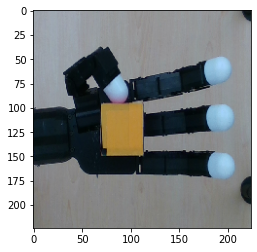

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img0[:,:,::-1])
plt.show()

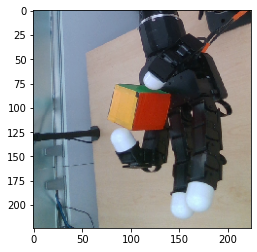

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img1[:,:,::-1])
plt.show()

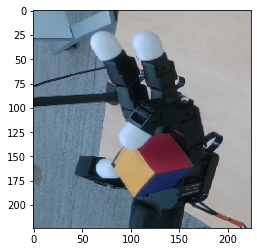

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img2[:,:,::-1])
plt.show()

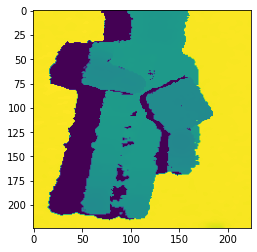

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(depth[0])
plt.show()

# Train function



In [ ]:
#create a helper function to calculate Root Mean Square Error for the competition

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


def train(epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch
    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):


        #shape of data is [64,224,224,9] target is [64,12]
        #now, we want to include depth as well, so we will have to make some tricks
        #reshape data from [64,224,224,9] to [64,9,224,224]

        #lets change some things inside-----------------------------------
        RGBs=torch.stack((data[0][:,:,:,0],data[0][:,:,:,1],data[0][:,:,:,2]),1)
        #concate depth
        #data=torch.cat((RGBs,data[3]), 1)
        
        data = RGBs

        #now data is [64,12,224,224], which matches with the target [64,12], and has the dim 224x224 per image

        #------------------------------------------------------------------
        
        data, target = data.to(device), target.to(device)
        
        #if we want to permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data.squeeze(),permutation_order)

        output = model(data)
        rmse_loss = RMSELoss()
        loss = rmse_loss(output.float(), target.float())

        optimizer.zero_grad()#reset gradients
        loss.backward()#calculate gradients
        optimizer.step()#update 

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# CNN Arquitecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.BatchNorm2d(3, affine=True),
            nn.Conv2d(in_channels=3, out_channels=conv_feature, kernel_size=5),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3), 
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(conv_features, affine=True),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3), 
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(conv_features, affine=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=conv_feature, out_channels=conv_feature, kernel_size=3)

        )
        
        self.linear_layers=nn.Sequential(
            torch.nn.Linear(conv_feature*39*39, 8096),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(p=0.6),
            torch.nn.Linear(8096, 8096),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(8096, output_size),
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        result = self.linear_layers(x)
        return result

 # Train and see loss
 

In [ ]:
# Training settings 
conv_features = 42 # number of feature maps used to be 52
fc_features = 50
output_size = 12

#regular

model_cnn = CNN(224*224,conv_features,fc_features,output_size) # create CNN model


model_cnn.to(device)

#changing learning rate

optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.11, momentum=0.81) # use SGD with learning rate 0.01 and momentum 0.5
# print('Number of parameters: {}'.format(get_n_params(model_cnn)))

#otherwise try adam as optimizer

test_accuracy = []
for epoch in range(0, 10):
    train(epoch, model_cnn, optimizer)

    
    
#     test_accuracy.append(test(model_cnn))

Train Epoch: 0 [0/3396 (0%)]	Loss: 0.066268
Train Epoch: 0 [840/3396 (24%)]	Loss: 0.027132
Train Epoch: 0 [1680/3396 (49%)]	Loss: 0.023194
Train Epoch: 0 [2520/3396 (73%)]	Loss: 0.019209
Train Epoch: 0 [1440/3396 (98%)]	Loss: 0.012196
Train Epoch: 1 [0/3396 (0%)]	Loss: 0.012288
Train Epoch: 1 [840/3396 (24%)]	Loss: 0.009500
Train Epoch: 1 [1680/3396 (49%)]	Loss: 0.008168
Train Epoch: 1 [2520/3396 (73%)]	Loss: 0.007348
Train Epoch: 1 [1440/3396 (98%)]	Loss: 0.007802
Train Epoch: 2 [0/3396 (0%)]	Loss: 0.007407
Train Epoch: 2 [840/3396 (24%)]	Loss: 0.006561
Train Epoch: 2 [1680/3396 (49%)]	Loss: 0.008798
Train Epoch: 2 [2520/3396 (73%)]	Loss: 0.006449
Train Epoch: 2 [1440/3396 (98%)]	Loss: 0.006034
Train Epoch: 3 [0/3396 (0%)]	Loss: 0.007019
Train Epoch: 3 [840/3396 (24%)]	Loss: 0.006631
Train Epoch: 3 [1680/3396 (49%)]	Loss: 0.006833
Train Epoch: 3 [2520/3396 (73%)]	Loss: 0.005727
Train Epoch: 3 [1440/3396 (98%)]	Loss: 0.005060
Train Epoch: 4 [0/3396 (0%)]	Loss: 0.005839
Train Epoch: 4 [

In [ ]:
torch.save(model_cnn.state_dict(), "model_cnn_capstone.pt")

In [ ]:
model_cnn.eval()

CNN(
  (cnn_layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 42, kernel_size=(5, 5), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (6): LeakyReLU(negative_slope=0.2)
    (7): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.2)
    (14): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Training settings 
conv_features = 42 # number of feature maps
fc_features = 50
output_size = 12

model_cnn = CNN(224*224,conv_features,fc_features,output_size) # create CNN model
#model_cnn = VGG16(num_classes= 12)

model_cnn.to(device)
model = model_cnn
model.load_state_dict(torch.load('model_cnn_capstone.pt'))
model.eval()

CNN(
  (cnn_layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 42, kernel_size=(5, 5), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (6): LeakyReLU(negative_slope=0.2)
    (7): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.2)
    (14): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

   # Now, lets model predictions for test and submit

In [ ]:
ids = []
img_data = []
for batch_idx, data in enumerate(test_loader):
        ids.extend(data[4].tolist())
        RGBs=torch.stack((data[0][:,:,:,0],data[0][:,:,:,1],data[0][:,:,:,2]),1)
        #concate depth
        #data=torch.cat((RGBs,data[3]),1)
        data = RGBs
        img_data.append(data)

In [ ]:
preds = []
for data in img_data:
    # Please remember to modify this loop, input and output based on your model/architecture
    output = model_cnn(data)
    preds.extend(output.cpu().detach().numpy())

In [ ]:
import pickle
import pandas as pd

outfile = 'submission.csv'

output_file = open(outfile, 'w')

In [ ]:
import pandas as pd
titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
df = pd.concat([pd.DataFrame(ids), pd.DataFrame(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file submission.csv
